# Mini-Meta

> Explanation of how to compute the meta-analyzed weighted effect size using dabest.

- order: 5

When scientists conduct replicates of the same experiment, the effect size of each replicate often varies, complicating the interpretation of the results. Starting from v2023.02.14, DABEST can now compute the meta-analyzed weighted effect size given multiple replicates of the same experiment. This can help resolve differences between replicates and simplify interpretation.

For this function, the generic *inverse-variance* weighting method is used to calculate a weighted mean difference, as follows:

$\hat{\Delta}_w = \frac{\sum\hat{\Delta}_i\,w_i}{\sum w_i},\quad w_i =\frac{1}{\hat{\sigma}_i^{2}},\quad \hat{\sigma}_i^{2} =\operatorname{var}\!\big(\hat{\Delta}_i\big)$

The variance used is calculated empirically as the sample variance of the bootstrapped values of the mean difference.


$\hat{\Delta}_w=\frac{\sum\hat{\Delta}_i\,\hat{w}_i}{\sum\hat{w}_i},\quad \hat{w}_i=\frac{n_i-1}{\sum_{r=1}^{n_i}\bigl(\hat{\Delta}_i^{(r)}-\bar{\Delta}_i^{\mathrm{b}}\bigr)^2},\quad \bar{\Delta}_i^{\mathrm{b}}=\frac{1}{n_i}\sum_{r=1}^{n_i}\hat{\Delta}_i^{(r)}.$

Where
$\hat{\Delta}_w$: estimated weighted delta;

$w_i$: weight for replicate $i$;

$\hat{\sigma}_i^2$: sampling variance of the mean-difference estimator for replicate $i$;

$\hat{\Delta}_i$: estimated mean difference for replicate $i$;

$\hat{w}_i$: estimated weight for replicate $i$;

$n_i$: number of bootstrap replicates used for replicate $i$;

$\hat{\Delta}_i^{(r)}$: the $r$-th bootstrap estimate of the mean difference for replicate $i$;

$\bar{\Delta}_i^{\mathrm{b}}$: bootstrap mean of the mean differences for replicate $i$

Note that this utilizes the fixed-effects model of meta-analysis, in contrast to the random-effects model. In the fixed-effects model, all variation between the results of each replicate is assumed to be solely due to sampling error. Therefore, we recommend using this function exclusively for replications of the same experiment, where it can be safely assumed that each replicate estimates the same population mean $\mu$.

Additionally, be aware that as of **v2023.02.14**, DABEST can only compute weighted effect size *for mean difference only*, and not for standardized measures such as Cohen's *d*.

For more information on meta-analysis, please refer to [Chapter 10 of the Cochrane handbook](https://training.cochrane.org/handbook/current/chapter-10).

## Load libraries

In [ ]:
import numpy as np
import pandas as pd
import dabest

print("We're using DABEST v{}".format(dabest.__version__))

Pre-compiling numba functions for DABEST...


Compiling numba functions: 100%|██████████| 11/11 [00:00<00:00, 38.07it/s]

Numba compilation complete!
We're using DABEST v2025.10.20


In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # to suppress warnings related to points not being able to be plotted due to dot size

## Creating a demo dataset

In [ ]:
from scipy.stats import norm # Used in generation of populations.

np.random.seed(9999) # Fix the seed to ensure reproducibility of results.
Ns = 20 # The number of samples taken from each population

# Create samples
c1 = norm.rvs(loc=3, scale=0.4, size=Ns)
c2 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
c3 = norm.rvs(loc=3.25, scale=0.4, size=Ns)

t1 = norm.rvs(loc=3.5, scale=0.5, size=Ns)
t2 = norm.rvs(loc=2.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=3, scale=0.75, size=Ns)


# Add a `gender` column for coloring the data.
females = np.repeat('Female', Ns/2).tolist()
males = np.repeat('Male', Ns/2).tolist()
gender = females + males

# Add an `id` column for paired data plotting.
id_col = pd.Series(range(1, Ns+1))

# Combine samples and gender into a DataFrame.
df = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                   'Control 2' : c2,     'Test 2' : t2,
                   'Control 3' : c3,     'Test 3' : t3,
                   'Gender'    : gender, 'ID'  : id_col
                  })
df.head()

,Control 1,Test 1,Control 2,Test 2,Control 3,Test 3,Gender,ID
0,2.793984,3.420875,3.324661,1.707467,3.816940,1.796581,Female,1
1,3.236759,3.467972,3.685186,1.121846,3.750358,3.944566,Female,2
2,3.019149,4.377179,5.616891,3.301381,2.945397,2.832188,Female,3
3,2.804638,4.564780,2.773152,2.534018,3.575179,3.048267,Female,4
4,2.858019,3.220058,2.550361,2.796365,3.692138,3.276575,Female,5


We now have three *Control* and three *Test* groups, simulating three replicates of the same experiment. Our
dataset has also a non-numerical column indicating gender, and another
column indicating the identity of each observation.

This is known as a 'wide' dataset. See this
[writeup](https://sejdemyr.github.io/r-tutorials/basics/wide-and-long/)
for more details.

## Loading data

Next, we load data as usual using ``dabest.load()``. However, this time, we also specify the argument ``mini_meta=True``. Since we are loading data from three experiments, ``idx`` is passed as a tuple of tuples, as shown below.

When this `dabest` object is invoked, it should indicate that effect sizes will be calculated for each group, along with the weighted delta. It is important to note once again that the weighted delta will only be calculated for mean differences.

In [ ]:
unpaired = dabest.load(df, idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), mini_meta=True)
unpaired

DABEST v2025.10.20
                  
Good afternoon!
The current time is Fri Oct 17 15:30:57 2025.

Effect size(s) with 95% confidence intervals will be computed for:
1. Test 1 minus Control 1
2. Test 2 minus Control 2
3. Test 3 minus Control 3
4. weighted delta (only for mean difference)

5000 resamples will be used to generate the effect size bootstraps.

By calling the ``mean_diff`` attribute, you can view the mean differences for each group as well as the weighted delta.


In [ ]:
unpaired.mean_diff

DABEST v2025.10.20
                  
Good afternoon!
The current time is Fri Oct 17 15:30:58 2025.

The unpaired mean difference between Control 1 and Test 1 is 0.48 [95%CI 0.205, 0.774].
The p-value of the two-sided permutation t-test is 0.001, calculated for legacy purposes only. 

The unpaired mean difference between Control 2 and Test 2 is -1.38 [95%CI -1.93, -0.905].
The p-value of the two-sided permutation t-test is 0.0, calculated for legacy purposes only. 

The unpaired mean difference between Control 3 and Test 3 is -0.255 [95%CI -0.696, 0.208].
The p-value of the two-sided permutation t-test is 0.293, calculated for legacy purposes only. 

The weighted-average unpaired mean differences is -0.00983 [95%CI -0.225, 0.213].
The p-value of the two-sided permutation t-test is 0.941, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size 

You can view the details of each experiment by accessing the property `mean_diff.results` as follows.

In [ ]:
pd.options.display.max_columns = 50
unpaired.mean_diff.results

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,bca_interval_idx,pct_low,pct_high,pct_interval_idx,bootstraps,resamples,random_seed,permutations,pvalue_permutation,permutation_count,permutations_var,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney,bec_difference,bec_bootstraps,bec_bca_interval_idx,bec_bca_low,bec_bca_high,bec_pct_interval_idx,bec_pct_low,bec_pct_high
0,Control 1,Test 1,20,20,mean difference,None,0.480290,95,0.205161,0.773647,"(145, 4893)",0.197427,0.758752,"(125, 4875)","[0.6148498102262239, 0.6752095203445543, 0.300...",5000,12345,"[-0.17259843762502491, 0.03802293852634886, -0...",0.0010,5000,"[0.26356588154404337, 0.2710249543904699, 0.26...",0.002094,-3.308806,0.002057,-3.308806,0.001625,83.0,0.0,"[-0.09732932551566487, 0.08087009665445155, -0...","(127, 4877)",-0.256862,0.259558,"(125, 4875)",-0.258260,0.257590
1,Control 2,Test 2,20,20,mean difference,None,-1.381085,95,-1.934192,-0.905164,"(94, 4838)",-1.901802,-0.877098,"(125, 4875)","[-1.7266697532252988, -1.7990605927248775, -1....",5000,12345,"[0.015164519971271773, 0.017231919606192303, -...",0.0000,5000,"[1.2241741427801065, 1.2241565174150129, 1.128...",0.000011,5.138840,0.000009,5.138840,0.000026,356.0,0.0,"[-0.7109511916465152, -0.3436697507223183, -0....","(126, 4876)",-0.578621,0.598647,"(125, 4875)",-0.579306,0.598009
2,Control 3,Test 3,20,20,mean difference,None,-0.254831,95,-0.696379,0.207659,"(123, 4873)",-0.694790,0.208585,"(125, 4875)","[0.3059887140714319, -0.22727011648745288, 0.0...",5000,12345,"[-0.05901068591042824, -0.13617667681797307, 0...",0.2934,5000,"[0.5835889750166371, 0.5796253365278035, 0.581...",0.294766,1.069798,0.291459,1.069798,0.285305,240.0,0.0,"[0.07996849455952271, 0.24534680794041375, 0.0...","(124, 4874)",-0.243754,0.240283,"(125, 4875)",-0.243713,0.240490


Note, however, that this does not contain the relevant information for our weighted delta. The details of the weighted delta are stored as attributes of the ``mini_meta`` object, such as:

  - ``group_var``: the pooled group variances of each set of 2 experiment groups.
  - ``difference``: the weighted mean difference calculated based on the raw data.
  - ``bootstraps``: the deltas of each set of 2 experiment groups calculated based on the bootstraps.
  - ``bootstraps_weighted_delta``: the weighted deltas calculated based on the bootstraps.
  - ``permutations``: the deltas of each set of 2 experiment groups calculated based on the permutation data.
  - ``permutations_var``: the pooled group variances of each set of 2 experiment groups calculated based on permutation data.
  - ``permutations_weighted_delta``: the weighted deltas calculated based on the permutation data.

A dataframe of this mini meta dabest object can also be called via the `mini_meta.results` attribute.

In [ ]:
unpaired.mean_diff.mini_meta.results

,control,test,control_N,test_N,control_var,test_var,group_var,difference,ci,bca_low,bca_high,bca_interval_idx,pct_low,pct_high,pct_interval_idx,bootstraps_deltas,bootstraps_weighted_delta,permutations,permutations_var,permutations_weighted_delta,pvalue_permutation,permutation_count,bias_correction,jackknives
0,"[Control 1, Control 2, Control 3]","[Test 1, Test 2, Test 3]","[20, 20, 20]","[20, 20, 20]","[0.17628013404546258, 0.9584767911266554, 0.16...","[0.24512071870152594, 0.48609989925165153, 0.9...","[0.2107004263734943, 0.7222883451891535, 0.567...",-0.00983,95,-0.225073,0.213221,"(133, 4883)",-0.227199,0.210616,"(125, 4875)","[[0.6148498102262239, 0.6752095203445543, 0.30...","[0.1383993266160009, 0.040698566036827026, -0....","[[-0.17259843762502491, 0.03802293852634886, -...","[[0.26356588154404337, 0.2710249543904699, 0.2...","[-0.11757207833491819, -0.01292867970093462, -...",0.9412,5000,0.014539,"[-0.010633066723935882, -0.010613522663007862,..."


## Generating mini meta plots

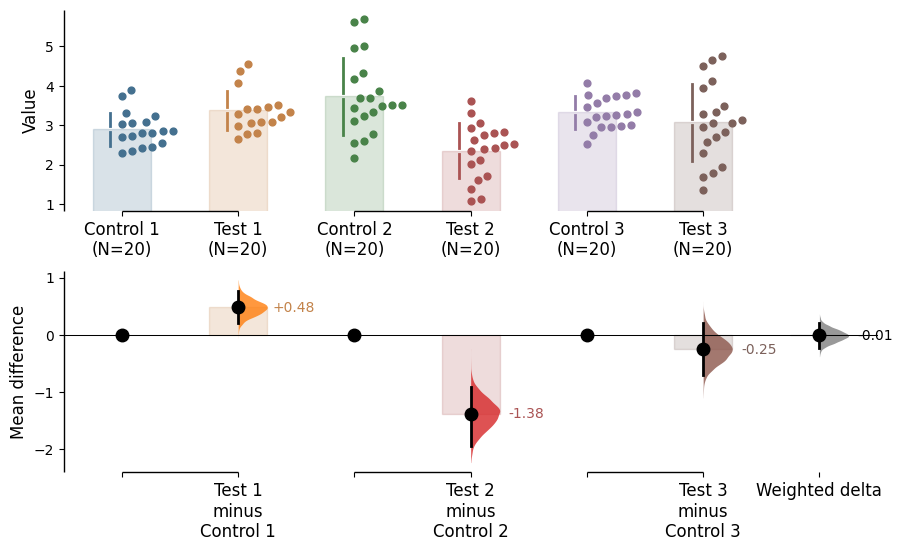

In [ ]:
unpaired.mean_diff.plot();

You can also hide the weighted delta by passing the argument ``show_mini_meta=False``. In this case, the resulting graph would be identical to a multiple two-groups plot.


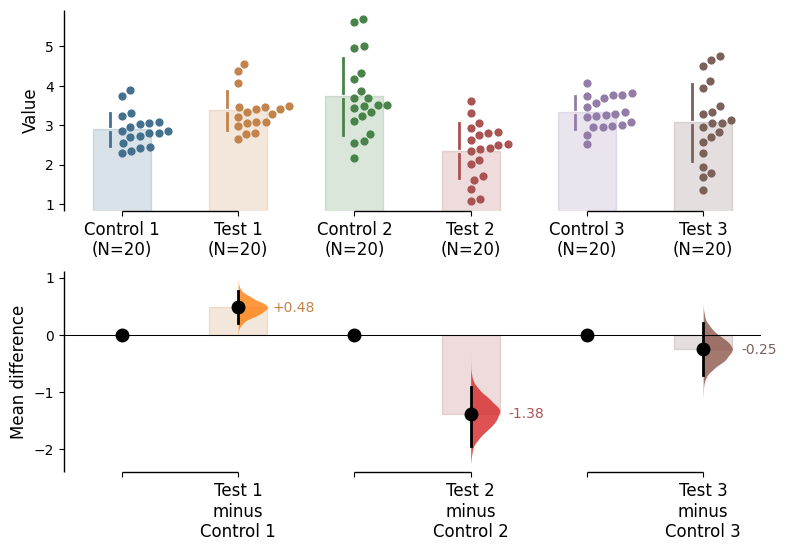

In [ ]:
unpaired.mean_diff.plot(show_mini_meta=False);

As with regular two-groups plots, you can also analyse paired mini meta experiments via the `paired=baseline` argument.

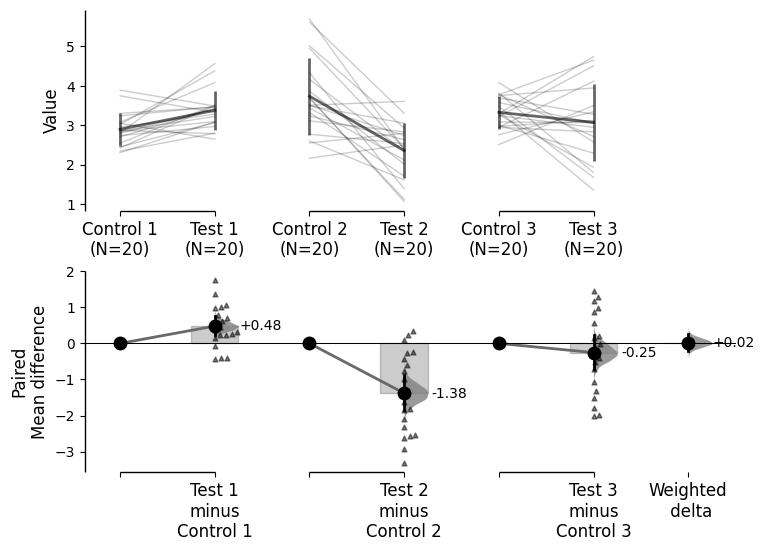

In [ ]:
paired = dabest.load(df, idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), mini_meta=True, id_col="ID", paired="baseline")
paired.mean_diff.plot();

For further aesthetic changes, the [Plot Aesthetics Tutorial](08-plot_aesthetics.html) provides detailed examples of how to customize the plot.
